<a href="https://colab.research.google.com/github/PabloPe4/Clustering_Test/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

spark-3.1.1-bin-hadoop2.7/
spark-3.1.1-bin-hadoop2.7/NOTICE
spark-3.1.1-bin-hadoop2.7/kubernetes/
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/python_executable_check.py
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/autoscale.py
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/decommissioning.py
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.1.1-bin-hadoop2.7/kubernetes/tests/decommissioning_cleanup.py
spark-3.1.1-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.1.1-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.1.1-bin-hadoop2.7/kubernetes/dockerfiles/spark/decom.sh
spark-3.1.1-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.1.1-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.1.1-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.1.1-bin-hadoop2.7/kubernetes/docker

In [2]:
#We define the environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [3]:
#We start a Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName('Clustering using K-Means')\
        .master("local[*]")\
        .getOrCreate()

df = spark\
    .read\
    .json("/content/Brisbane_CityBike.json")
    
df.printSchema()
df.show()

root
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- number: long (nullable = true)

+--------------------+----------+----------+--------------------+------+
|             address|  latitude| longitude|                name|number|
+--------------------+----------+----------+--------------------+------+
|Lower River Tce /...|-27.482279|153.028723|122 - LOWER RIVER...|   122|
|Main St / Darragh St| -27.47059|153.036046|91 - MAIN ST / DA...|    91|
|Sydney St Ferry T...|-27.474531|153.042728|88 - SYDNEY ST FE...|    88|
|Browne St / James St|-27.461881|153.046986|75 - BROWNE ST / ...|    75|
|Kurilpa Point / M...|-27.469658|153.016696|98 - KURILPA POIN...|    98|
|Montague Rd / Ski...| -27.48172| 153.00436|109 - MONTAGUE RD...|   109|
|Macquarie St / Gu...|-27.493626|153.001482|149 - MACQUARIE S...|   149|
|Bi-centennial Bik...|-27.476076|153.002459|139 - BI-CENTENNI...|   139|

In [4]:
spark

In [5]:
df = df.na.drop()

In [6]:
#Already have a number column but if we didn't we could extract the number of the street as follows:
'''from pyspark.sql.functions import substring_index
df = df\
.withColumn("num_name", substring_index(df.name, '-', 1))
'''

'from pyspark.sql.functions import substring_index\ndf = df.withColumn("num_name", substring_index(df.name, \'-\', 1))\n'

In [7]:
from pyspark.ml.feature import VectorAssembler
df.columns
assemble = VectorAssembler(inputCols=[
 'latitude',
 'longitude',
 'number'], outputCol='features')
assembled_data = assemble.transform(df)
assembled_data.show(5)

+--------------------+----------+----------+--------------------+------+--------------------+
|             address|  latitude| longitude|                name|number|            features|
+--------------------+----------+----------+--------------------+------+--------------------+
|Lower River Tce /...|-27.482279|153.028723|122 - LOWER RIVER...|   122|[-27.482279,153.0...|
|Main St / Darragh St| -27.47059|153.036046|91 - MAIN ST / DA...|    91|[-27.47059,153.03...|
|Sydney St Ferry T...|-27.474531|153.042728|88 - SYDNEY ST FE...|    88|[-27.474531,153.0...|
|Browne St / James St|-27.461881|153.046986|75 - BROWNE ST / ...|    75|[-27.461881,153.0...|
|Kurilpa Point / M...|-27.469658|153.016696|98 - KURILPA POIN...|    98|[-27.469658,153.0...|
+--------------------+----------+----------+--------------------+------+--------------------+
only showing top 5 rows



In [8]:
#In this case standardization does not improve the result due to the nature of the data
#However, it would likely be a good practice for other cases.
from pyspark.ml.feature import StandardScaler
scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show(5)

+--------------------+----------+----------+--------------------+------+--------------------+--------------------+
|             address|  latitude| longitude|                name|number|            features|        standardized|
+--------------------+----------+----------+--------------------+------+--------------------+--------------------+
|Lower River Tce /...|-27.482279|153.028723|122 - LOWER RIVER...|   122|[-27.482279,153.0...|[-2523.2742070775...|
|Main St / Darragh St| -27.47059|153.036046|91 - MAIN ST / DA...|    91|[-27.47059,153.03...|[-2522.2009863229...|
|Sydney St Ferry T...|-27.474531|153.042728|88 - SYDNEY ST FE...|    88|[-27.474531,153.0...|[-2522.5628276262...|
|Browne St / James St|-27.461881|153.046986|75 - BROWNE ST / ...|    75|[-27.461881,153.0...|[-2521.4013730496...|
|Kurilpa Point / M...|-27.469658|153.016696|98 - KURILPA POIN...|    98|[-27.469658,153.0...|[-2522.1154151241...|
+--------------------+----------+----------+--------------------+------+--------

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
k_list = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    k_list.append(i)
    
    print("Silhouette Score:",score,i)

Silhouette Score: 0.9897418863775583 2
Silhouette Score: 0.7808236897005427 3
Silhouette Score: 0.740191253635451 4
Silhouette Score: 0.718581946066027 5
Silhouette Score: 0.7050348829505197 6
Silhouette Score: 0.6987762195847674 7
Silhouette Score: 0.6930135661844099 8
Silhouette Score: 0.6809954404846525 9


In [10]:
#If we needed to have a DataFrame with the silhouette score for each K
'''lst = [silhouette_score, k_list]
from pyspark.sql import Row

R = Row("silhouette_score", "k")
sc.parallelize([R(*r) for r in zip(*lst)]).toDF().show()'''

'lst = [silhouette_score, k_list]\nfrom pyspark.sql import Row\n\nR = Row("silhouette_score", "k")\nsc.parallelize([R(*r) for r in zip(*lst)]).toDF().show()'

Text(0, 0.5, 'cost')

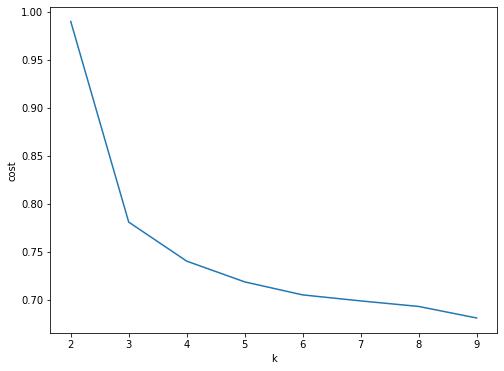

In [11]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [12]:
# Train a k-means model.
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(assembled_data.select("features"))
predictions = model.transform(assembled_data.select("features"))

In [13]:
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-27.482279,153.0...|         3|
|[-27.47059,153.03...|         2|
|[-27.474531,153.0...|         2|
|[-27.461881,153.0...|         2|
|[-27.469658,153.0...|         2|
|[-27.48172,153.00...|         3|
|[-27.493626,153.0...|         3|
|[-27.476076,153.0...|         3|
|[-27.493963,153.0...|         0|
|[-27.482197,153.0...|         3|
|[-27.465226,153.0...|         2|
|[-27.468447,153.0...|         1|
|[-27.473021,153.0...|         0|
|[-27.457825,153.0...|         2|
|[-27.48148,153.02...|         2|
|[-27.467464,153.0...|         0|
|[-27.499963,153.0...|         2|
|[-27.490776,152.9...|         3|
|[-27.458199,153.0...|         2|
|[-27.481808,153.0...|         3|
+--------------------+----------+
only showing top 20 rows



In [14]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.740191253635451


In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-27.4690128  153.02600845  26.44897959]
[ -27.468447  153.024662 1101.      ]
[-27.46422244 153.03826154  76.5       ]
[-27.48088135 153.01071869 126.        ]


In [16]:
#We trasnform both DFs to Pandas DFs so that we can merge them
df_pred = predictions.toPandas()
df_pd = assembled_data.toPandas()

In [17]:
#We stop the Spark Session to avoid misuse of resources
spark.stop()

In [18]:
import pandas as pd
df_total = pd.merge(df_pd, df_pred, on='features')
df_total

,address,latitude,longitude,name,number,features,prediction
0,Lower River Tce / Ellis St,-27.482279,153.028723,122 - LOWER RIVER TCE / ELLIS ST,122,"[-27.482279, 153.028723, 122.0]",3
1,Main St / Darragh St,-27.470590,153.036046,91 - MAIN ST / DARRAGH ST,91,"[-27.47059, 153.036046, 91.0]",2
2,Sydney St Ferry Terminal / Park,-27.474531,153.042728,88 - SYDNEY ST FERRY TERMINAL / PARK,88,"[-27.474531, 153.042728, 88.0]",2
3,Browne St / James St,-27.461881,153.046986,75 - BROWNE ST / JAMES ST,75,"[-27.461881, 153.046986, 75.0]",2
4,Kurilpa Point / Montague Rd,-27.469658,153.016696,98 - KURILPA POINT / MONTAGUE RD,98,"[-27.469658, 153.016696, 98.0]",2
...,...,...,...,...,...,...,...
144,38 - Ann St / Creek St,-27.465880,153.026861,38 - ANN ST / CREEK ST,38,"[-27.46588, 153.026861, 38.0]",0
145,Albert St Mall / Elizabeth St,-27.470110,153.025627,14 - ALBERT STREET MALL / ELIZABETH STREET,14,"[-27.47011, 153.025627, 14.0]",0
146,Turbot St / Bowen St,-27.462665,153.029087,45 - TURBOT ST / BOWEN ST,45,"[-27.462665, 153.029087, 45.0]",0
147,Edward St / Queen St,-27.468120,153.026820,1 - EDWARD ST / QUEEN ST,1,"[-27.46812, 153.02682, 1.0]",0


In [19]:
#We make sure the types of the DF are as desired
df_total.dtypes

address        object
latitude      float64
longitude     float64
name           object
number          int64
features       object
prediction      int32
dtype: object

In [20]:
#We export the DF to a json format so that we could use it again later the same way
df_total.to_json(r'/content/result.json')

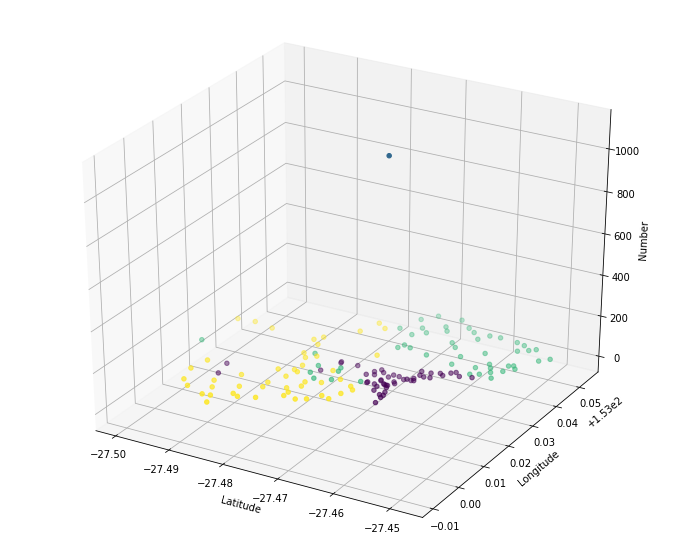

In [21]:
#Extra visualization to have a better understanding of the clusters
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(df_total.latitude, df_total.longitude, df_total.number, c=df_total.prediction)
threedee.set_xlabel('Latitude')
threedee.set_ylabel('Longitude')
threedee.set_zlabel('Number')
plt.show()